Run the following cell to install Fenics on Google Colab.

In [ ]:
!wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install-real.sh" && bash "/tmp/fenics-install-real.sh"
import dolfin

--2024-05-23 12:58:53--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install-real.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-05-23 12:58:54 (36.4 MB/s) - ‘/tmp/fenics-install-real.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e133a01/releases/pyb

# Linear convection-diffusion equation

Consider the stationnary convection-diffusion equation

\begin{equation}
-\kappa \Delta u + \beta \cdot \nabla u + \gamma u= f \quad x\in\Omega :=(0,1)^2 \\
u|_{\partial \Omega}=0,
\end{equation}

with the following parameters:

\begin{equation}
\kappa = 10^{-2}, \quad \beta=[0.4, 1.0], \quad \gamma=0, \quad f(x,y)=\begin{cases} +1 & y\geq 2x, \\ -1 & y<2x\end{cases}
\end{equation}



## Numerical solution

In [ ]:
import fenics
from fenics import *
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
kappa = 10e-2
beta1 = 0.4
beta2 = 1.

mesh = UnitSquareMesh(1000, 1000)
V = FunctionSpace(mesh, "P", 1)

u_D = Constant(0.0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

u = TrialFunction(V)
v = TestFunction(V)

f = Expression("x[1] >= 2*x[0] ? 1 : -1", degree=1)

beta = Constant((beta1, beta2))

a = Constant(kappa) * inner(nabla_grad(u), nabla_grad(v)) * dx + inner(beta, nabla_grad(u)) * v * dx

L = f*v*dx

u = Function(V)
solve(a == L, u, bc)

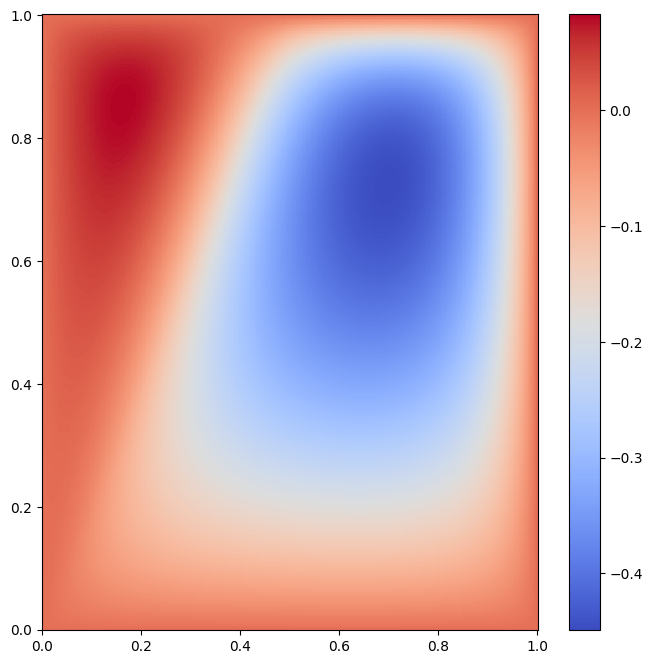

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

x = np.linspace(0, 1, 400)
xx, yy = np.meshgrid(x, x)

zz = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        zz[i,j] = u(xx[i, j], yy[i, j])

h = ax.pcolormesh(x, x, zz, shading="auto", cmap="coolwarm")
fig.colorbar(h)
plt.show()

## PINN's Solution

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import numpy as np

In [ ]:
def f(x):
  return tf.concat([tf.sin(x), tf.cos(x)], 0)
x = tf.Variable([np.pi/2])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    u = f(x)
    nabla_u = tape.gradient(u, x)
u_xxyy = tape.gradient(nabla_u, x)

nabla_u


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>

In [ ]:
class DNN(keras.Model):
    def __init__(self, layers_size):
        super(DNN, self).__init__()
        self.depth = len(layers_size) - 1
        self.layers_list = []
        for i in range(self.depth - 1):
            self.layers_list.append(layers.Dense(layers_size[i+1], activation='tanh'))
        self.layers_list.append(layers.Dense(layers_size[-1]))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

class PINN:
    def __init__(self, layers_size):
        self.dnn = DNN(layers_size)

    def generate_train_data_grid(self, num):
        # Boundary
        x = tf.cast(tf.linspace(0, 1, num), tf.float32)
        bc1 = tf.stack([tf.zeros(num), x], 1)
        bc2 = tf.stack([tf.ones(num), x], 1)
        bc3 = tf.stack([x, tf.zeros(num)], 1)
        bc4 = tf.stack([x, tf.ones(num)], 1)

        self.boundary = tf.concat([bc1, bc2, bc3, bc4],0)

        # Interior
        xx, yy = tf.meshgrid(x[1:-1], x[1:-1])
        self.interior = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], 1)

    def generate_train_data_random_uniform(self, num):
        self.interior = tf.random.uniform((num*num, 2))

        bc1 = tf.stack([tf.zeros(num), tf.random.uniform((num,))], 1)
        bc2 = tf.stack([tf.ones(num), tf.random.uniform((num,))], 1)
        bc3 = tf.stack([tf.random.uniform((num,)), tf.zeros(num)], 1)
        bc4 = tf.stack([tf.random.uniform((num,)), tf.ones(num)], 1)
        self.boundary = tf.concat([bc1, bc2, bc3, bc4],0)


    def u(self, x):
        return self.dnn(x)

    def f(self, x):
        return tf.math.sign(x[:, 1]-2*x[:, 0]) - tf.math.sign(2*x[:, 0]-x[:, 1])

    def loss(self):
        # Interior
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.interior)
            u = self.u(self.interior)
            nabla_u = tape.gradient(u, self.interior)
        Delta_u = tape.gradient(nabla_u, self.interior)
        del tape

        interior_loss = -kappa * (Delta_u[:, 0] + Delta_u[:, 1]) + beta1*nabla_u[:, 0] + beta2*nabla_u[:, 1] - self.f(self.interior)

        # Boundary
        boundary_loss = self.u(self.boundary)

        loss = tf.reduce_mean(tf.square(interior_loss)) + tf.reduce_mean(tf.square(boundary_loss))

        return loss

    def train(self, epochs, num, lr=0.001, distr="grid"):
        if distr == "grid":
            self.generate_train_data_grid(num)
        else:
            self.generate_train_data_random_uniform(num)

        losses = np.zeros(epochs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        for i in range(epochs):
            with tf.GradientTape() as tape:
                loss_value = self.loss()
            grads = tape.gradient(loss_value, self.dnn.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.dnn.trainable_weights))
            losses[i] = loss_value.numpy()
            if i%500==0:
              print("iter {} loss is: {}".format(i, losses[i]) )
        return losses

    def plot_solution(self):
        x = np.linspace(0, 1, 400)
        xx, yy = np.meshgrid(x, x)
        data = np.stack((xx, yy), axis=2).reshape(-1, 2)
        u = self.dnn(data)

        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)

        h = ax.pcolormesh(x, x, u.numpy().reshape(400, 400).T, shading="auto", cmap="coolwarm")
        fig.colorbar(h)
        ax.plot(self.interior[:, 0], self.interior[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)
        ax.plot(self.boundary[:, 0], self.boundary[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)
        plt.show()

model = PINN([2, 64, 64, 64, 64, 1])
losses = model.train(5000, 45, lr=0.001)


iter 0 loss is: 4.193169593811035
iter 100 loss is: 0.6016569137573242
iter 200 loss is: 0.356893390417099
iter 300 loss is: 0.32888737320899963
iter 400 loss is: 0.29485154151916504
iter 500 loss is: 0.2638244330883026
iter 600 loss is: 0.18219399452209473
iter 700 loss is: 0.12077179551124573
iter 800 loss is: 0.0815921202301979
iter 900 loss is: 0.04069698601961136
iter 1000 loss is: 0.017240241169929504
iter 1100 loss is: 0.008510779589414597
iter 1200 loss is: 0.010073634795844555
iter 1300 loss is: 0.003975502215325832
iter 1400 loss is: 0.003246752079576254
iter 1500 loss is: 0.00290135620161891
iter 1600 loss is: 0.0031894962303340435
iter 1700 loss is: 0.002184581942856312
iter 1800 loss is: 0.0019752467051148415
iter 1900 loss is: 0.001825954532250762
iter 2000 loss is: 0.002373439259827137


KeyboardInterrupt: 

In [ ]:
losses = model.train(5000, 45, lr=0.0001)

iter 0 loss is: 0.0017423382960259914
iter 100 loss is: 0.0015947315841913223
iter 200 loss is: 0.0015445916214957833
iter 300 loss is: 0.0014849675353616476
iter 400 loss is: 0.00142010860145092
iter 500 loss is: 0.0013534219469875097
iter 600 loss is: 0.0012890795478597283
iter 700 loss is: 0.0012280021328479052
iter 800 loss is: 0.0011859242804348469
iter 900 loss is: 0.0011196150444447994
iter 1000 loss is: 0.001067240722477436
iter 1100 loss is: 0.0010187162552028894
iter 1200 loss is: 0.0009758820524439216
iter 1300 loss is: 0.0009744428098201752
iter 1400 loss is: 0.0008983538718894124
iter 1500 loss is: 0.0008648309158161283
iter 1600 loss is: 0.0008372582378797233
iter 1700 loss is: 0.0008040275424718857
iter 1800 loss is: 0.0007771594682708383
iter 1900 loss is: 0.0007537748315371573
iter 2000 loss is: 0.0007315294933505356
iter 2100 loss is: 0.0007138054352253675
iter 2200 loss is: 0.0006933888653293252
iter 2300 loss is: 0.0006721508107148111
iter 2400 loss is: 0.0006488638

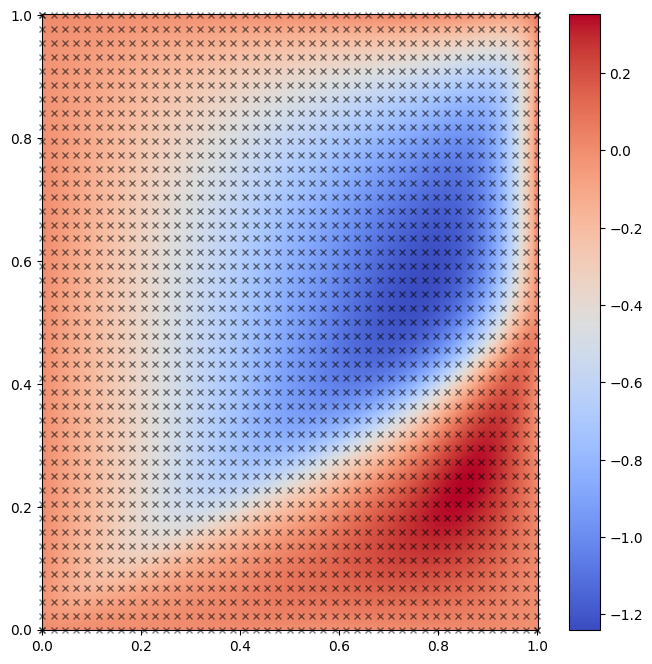

In [ ]:
model.plot_solution()